In [2]:
import numpy as np
import tensorflow as tf
import keras

D1019 05:32:26.031269991  135577 config.cc:119]                        gRPC EXPERIMENT tcp_frame_size_tuning               OFF (default:OFF)
D1019 05:32:26.031309408  135577 config.cc:119]                        gRPC EXPERIMENT tcp_rcv_lowat                       OFF (default:OFF)
D1019 05:32:26.031313555  135577 config.cc:119]                        gRPC EXPERIMENT peer_state_based_framing            OFF (default:OFF)
D1019 05:32:26.031316379  135577 config.cc:119]                        gRPC EXPERIMENT flow_control_fixes                  ON  (default:ON)
D1019 05:32:26.031318649  135577 config.cc:119]                        gRPC EXPERIMENT memory_pressure_controller          OFF (default:OFF)
D1019 05:32:26.031323575  135577 config.cc:119]                        gRPC EXPERIMENT unconstrained_max_quota_buffer_size OFF (default:OFF)
D1019 05:32:26.031326418  135577 config.cc:119]                        gRPC EXPERIMENT new_hpack_huffman_decoder           ON  (default:ON)
D1019 05:32:26.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import tensorflow as tf

# Define the paths to your custom dataset
train_data_dir = "/kaggle/input/vgg16-exe-anemic-dataset/VGG16_Classification/train"
validation_data_dir = "/kaggle/input/vgg16-exe-anemic-dataset/VGG16_Classification/val"
test_data_dir = "/kaggle/input/vgg16-exe-anemic-dataset/VGG16_Classification/test"

# You can use TensorFlow's `tf.keras.utils.image_dataset_from_directory` to load your dataset.
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="binary",  # Change this to "binary" or "int" if needed.
    image_size=(256, 256),  # Adjust image size as per your model's requirements.
    batch_size=32,  # Adjust batch size as needed.
    validation_split=0.1,  # 10% of the data will be used for validation.
    subset="training",
    seed=1337,  # You can change this for reproducibility.
)

validation_ds = tf.keras.utils.image_dataset_from_directory(
    train_data_dir,
    labels="inferred",
    label_mode="binary",  # Change this to "binary" or "int" if needed.
    image_size=(256, 256),  # Adjust image size as per your model's requirements.
    batch_size=32,  # Adjust batch size as needed.
    validation_split=0.1,  # 10% of the data will be used for validation.
    subset="validation",
    seed=1337,  # You can change this for reproducibility.
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels="inferred",
    label_mode="binary",  # Change this to "binary" or "int" if needed.
    image_size=(256, 256),  # Adjust image size as per your model's requirements.
    batch_size=32,  # Adjust batch size as needed.
)

# Print the number of samples in each dataset
print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))


Found 800 files belonging to 2 classes.
Using 720 files for training.
Found 800 files belonging to 2 classes.
Using 80 files for validation.
Found 100 files belonging to 2 classes.
Number of training samples: 23
Number of validation samples: 3
Number of test samples: 4


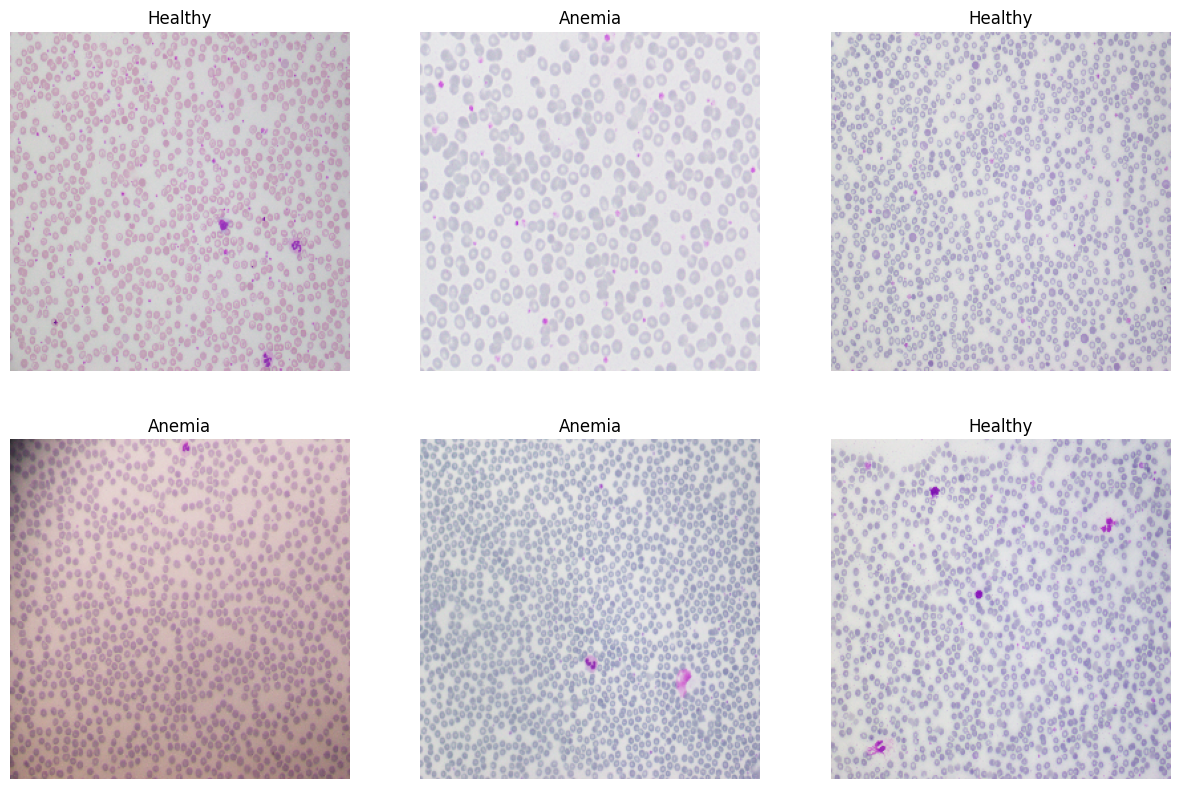

In [10]:
import matplotlib.pyplot as plt

# Assuming you want to display 9 images from the training set
num_images_to_display = 6

# Create a batch of images and labels from your custom dataset
for images, labels in train_ds.take(1):  # Take one batch of images and labels
    plt.figure(figsize=(15, 15))
    for i in range(num_images_to_display):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # Display the i-th image in the batch
        label = labels[i].numpy()
        class_name = "Anemia" if label[0] == 1 else "Healthy"
        plt.title(class_name)
        plt.axis("off")

plt.show()


In [11]:
batch_size = 32

# Cache, batch, and prefetch your custom dataset
train_ds = train_ds.cache()
#train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=10)

validation_ds = validation_ds.cache()
#validation_ds = validation_ds.batch(batch_size)
validation_ds = validation_ds.prefetch(buffer_size=10)

test_ds = test_ds.cache()
#test_ds = test_ds.batch(batch_size)
test_ds = test_ds.prefetch(buffer_size=10)


In [23]:
base_model = keras.applications.MobileNetV2(
    weights="imagenet",
    input_shape=(256, 256, 3),
    include_top=False,
    alpha=1.0  # Width multiplier - affects the number of filters in each layer. Can be 0.35, 0.50, 0.75, 1.0, 1.3, or 1.4
)

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(256, 256, 3))

# MobileNetV2 requires input pixel values in the range [-1, +1], so we need the rescaling layer.
x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

# Pass the input through the base model
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)

model = keras.Model(inputs, outputs)

model.summary()


Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_4 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_4   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1280)              0         
                                                                 
 dense_4 (Dense)             (None, 1)                 1281

In [24]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    base_model = keras.applications.MobileNetV2(
        weights="imagenet",
        input_shape=(256, 256, 3),
        include_top=False,
        alpha=1.0
    )

    # Freeze the base_model
    base_model.trainable = False

    # Create new model on top
    inputs = keras.Input(shape=(256, 256, 3))

    # MobileNetV2 requires input pixel values in the range [-1, +1], so we need the rescaling layer.
    x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

    # Pass the input through the base model
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    model.summary()




INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_5 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_5   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_5 (Dropout)         (None, 1280)              0         
                                                                 
 dense_5 (Dense)             (None, 1)                 1281

In [25]:
epochs = 300
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/300


2023-10-19 05:58:38.335474: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-10-19 05:58:38.608165: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


23/23 [==============================] - ETA: 0s - loss: 0.7025 - binary_accuracy: 0.5500

2023-10-19 05:58:52.242941: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-19 05:58:52.461935: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


23/23 [==============================] - 29s 839ms/step - loss: 0.7025 - binary_accuracy: 0.5500 - val_loss: 0.6268 - val_binary_accuracy: 0.5125
Epoch 2/300
23/23 [==============================] - 2s 87ms/step - loss: 0.5666 - binary_accuracy: 0.6931 - val_loss: 0.5720 - val_binary_accuracy: 0.6125
Epoch 3/300
23/23 [==============================] - 1s 62ms/step - loss: 0.5204 - binary_accuracy: 0.7278 - val_loss: 0.5543 - val_binary_accuracy: 0.6375
Epoch 4/300
23/23 [==============================] - 1s 65ms/step - loss: 0.4937 - binary_accuracy: 0.7514 - val_loss: 0.5303 - val_binary_accuracy: 0.6625
Epoch 5/300
23/23 [==============================] - 1s 62ms/step - loss: 0.4650 - binary_accuracy: 0.7528 - val_loss: 0.5159 - val_binary_accuracy: 0.6625
Epoch 6/300
23/23 [==============================] - 1s 61ms/step - loss: 0.4565 - binary_accuracy: 0.7653 - val_loss: 0.4960 - val_binary_accuracy: 0.7125
Epoch 7/300
23/23 [==============================] - 1s 62ms/step - loss: 

In [10]:
# model.compile(
#     optimizer=keras.optimizers.Adam(),
#     loss=keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=[keras.metrics.BinaryAccuracy()],
# )

# epochs = 20
# history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

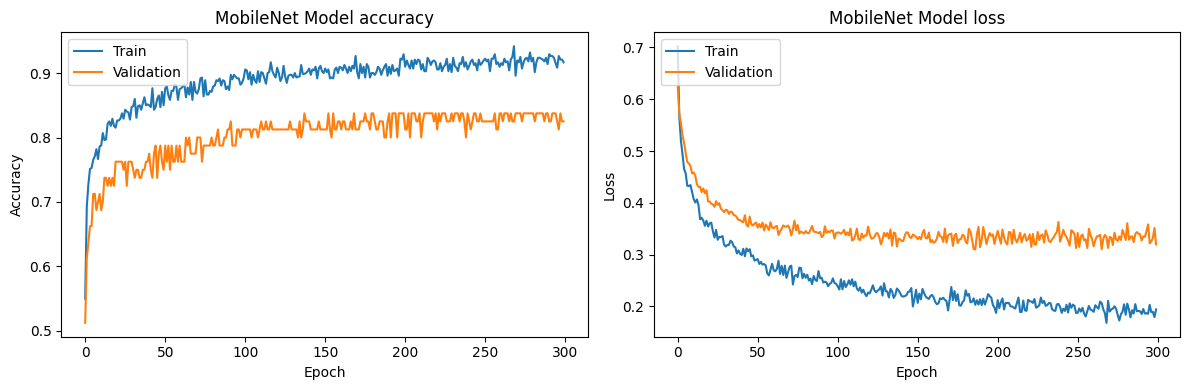

In [26]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('MobileNet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNet Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


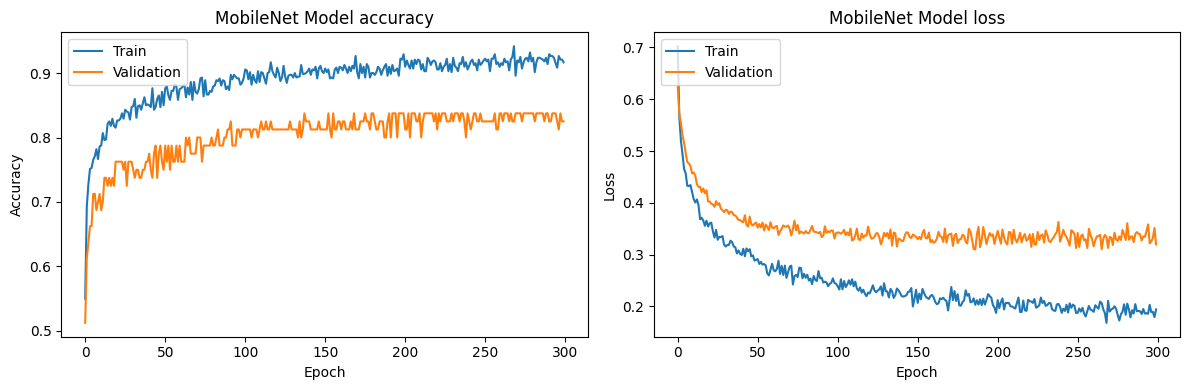

In [27]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('MobileNet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNet Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

# Define the file path where you want to save the plot
save_dir = "/kaggle/working/"
file_name = "training_plot_before_ft.png"

# Save the plot with high resolution (dpi)
plt.savefig(save_dir + file_name, dpi=300)  # Adjust dpi as needed

# Show the plot if you want to display it
plt.show()


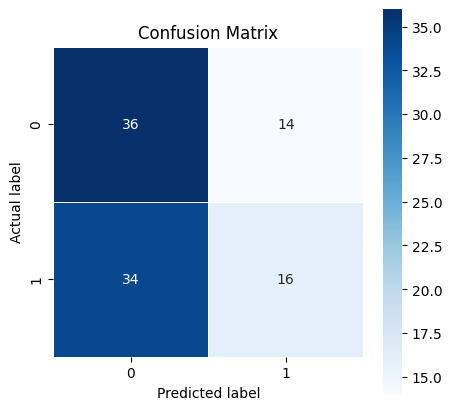

In [35]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


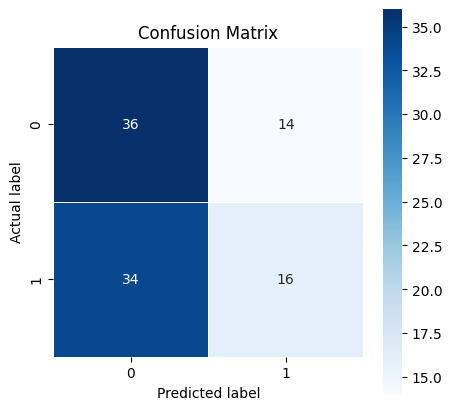

In [36]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')

# Define the file path where you want to save the confusion matrix plot
save_dir = "/kaggle/working/"
file_name = "confusion_matrix_before_ft.png"

# Save the plot with high resolution (dpi)
plt.savefig(save_dir + file_name, dpi=300)  # Adjust dpi as needed

# Show the plot if you want to display it
plt.show()


In [18]:
!pip install seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 5.8 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 23.0.1 -> 23.3
[notice] To update, run: pip install --upgrade pip


In [3]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.
INFO:tensorflow:Initializing the TPU system: local
INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


In [12]:
    
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    # Load the base MobileNetV2 model
    base_model = keras.applications.MobileNetV2(
        weights="imagenet",
        input_shape=(256, 256, 3),
        include_top=False,
        alpha=1.0
    )

    # Unfreeze the base_model layers
    base_model.trainable = True  # Set to True to fine-tune

    # Create new model on top
    inputs = keras.Input(shape=(256, 256, 3))

    # MobileNetV2 requires input pixel values in the range [-1, +1], so we need the rescaling layer.
    x = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)(inputs)

    # Pass the input through the base model
    x = base_model(x, training=False)
    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
    outputs = keras.layers.Dense(1)(x)

    model = keras.Model(inputs, outputs)

    # Set a very low learning rate (1e-5)
    custom_optimizer = keras.optimizers.Adam(learning_rate=1e-5)

    model.compile(
        optimizer=custom_optimizer,
        loss=keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[keras.metrics.BinaryAccuracy()],
    )

    model.summary()
epochs = 200
history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 256, 256, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_3   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_3 (Dropout)         (None, 1280)              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 1281

2023-10-19 05:41:54.684435: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.
2023-10-19 05:41:55.164413: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/Adam/AssignAddVariableOp.


23/23 [==============================] - ETA: 0s - loss: 0.5797 - binary_accuracy: 0.6542

2023-10-19 05:42:33.415507: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-19 05:42:33.609582: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


23/23 [==============================] - 64s 1s/step - loss: 0.5797 - binary_accuracy: 0.6542 - val_loss: 0.4612 - val_binary_accuracy: 0.7875
Epoch 2/200
23/23 [==============================] - 2s 81ms/step - loss: 0.4421 - binary_accuracy: 0.7806 - val_loss: 0.3764 - val_binary_accuracy: 0.8500
Epoch 3/200
23/23 [==============================] - 2s 79ms/step - loss: 0.3816 - binary_accuracy: 0.8139 - val_loss: 0.3265 - val_binary_accuracy: 0.8500
Epoch 4/200
23/23 [==============================] - 2s 78ms/step - loss: 0.3478 - binary_accuracy: 0.8292 - val_loss: 0.3182 - val_binary_accuracy: 0.8250
Epoch 5/200
23/23 [==============================] - 2s 81ms/step - loss: 0.3333 - binary_accuracy: 0.8458 - val_loss: 0.2914 - val_binary_accuracy: 0.8375
Epoch 6/200
23/23 [==============================] - 2s 78ms/step - loss: 0.3057 - binary_accuracy: 0.8472 - val_loss: 0.2825 - val_binary_accuracy: 0.8500
Epoch 7/200
23/23 [==============================] - 2s 78ms/step - loss: 0.2

In [13]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
# base_model.trainable = True
# model.summary()

# model.compile(
#     optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
#     loss=keras.losses.BinaryCrossentropy(from_logits=True),
#     metrics=[keras.metrics.BinaryAccuracy()],
# )

# epochs = 200
# history = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

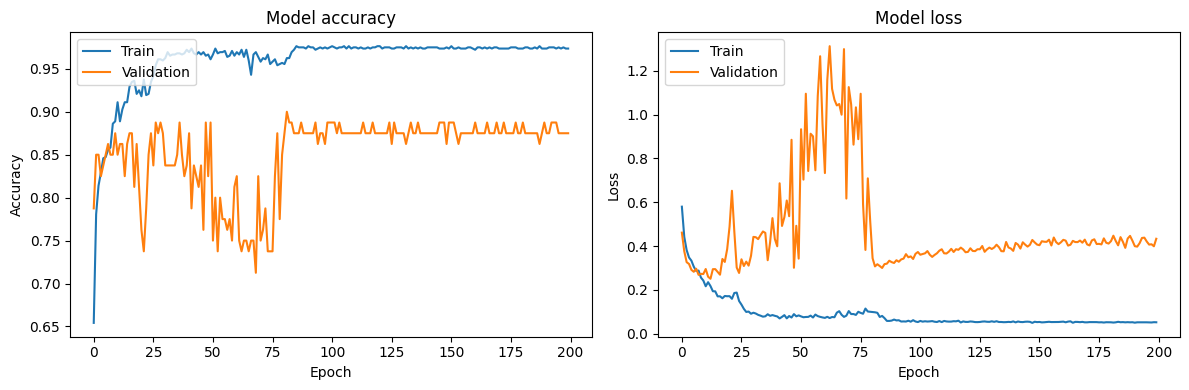

In [14]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('MobileNet Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('MobileNet Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [16]:
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test accuracy: {test_accuracy}")


4/4 [==============================] - 1s 22ms/step - loss: 1.9794 - binary_accuracy: 0.6400
Test accuracy: 0.6399999856948853


In [17]:
# Get the model's predictions on the test dataset
y_pred = model.predict(test_ds)
y_pred = tf.sigmoid(y_pred).numpy()  # Apply sigmoid to get probabilities
y_true = []
for _, labels in test_ds:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)


2023-10-19 05:51:54.095131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.
2023-10-19 05:51:54.297661: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.


4/4 [==============================] - 13s 2s/step


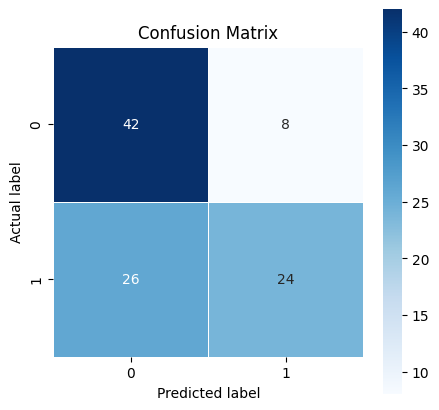

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred_binary)
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


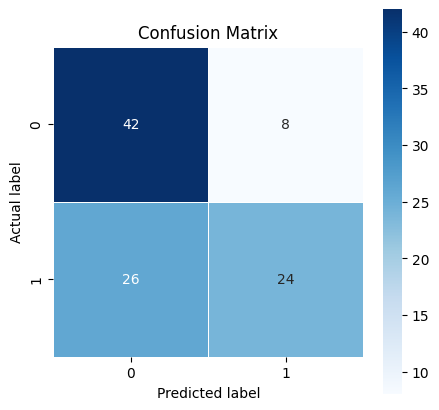

In [22]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_binary)

plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square=True, cmap='Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('MobileNet Confusion Matrix')

# Define the file path where you want to save the confusion matrix plot
save_dir = "/kaggle/working/"
file_name = "confusion_matrix_after_ft.png"

# Save the plot with high resolution (dpi)
plt.savefig(save_dir + file_name, dpi=300)  # Adjust dpi as needed

# Show the plot if you want to display it
plt.show()
